In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

Let's load the dataset and print out it's head to get a reminder of what it looks like.

In [2]:
starcraft_data = pd.read_csv('wrangled_starcraft_data.csv')
starcraft_data.drop('Unnamed: 0', axis=1, inplace=True)
starcraft_data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


Let's make a heatmap to see which variables correlate most to our target variable of League Index

Text(0.5, 1.0, 'Pearson Heat Map')

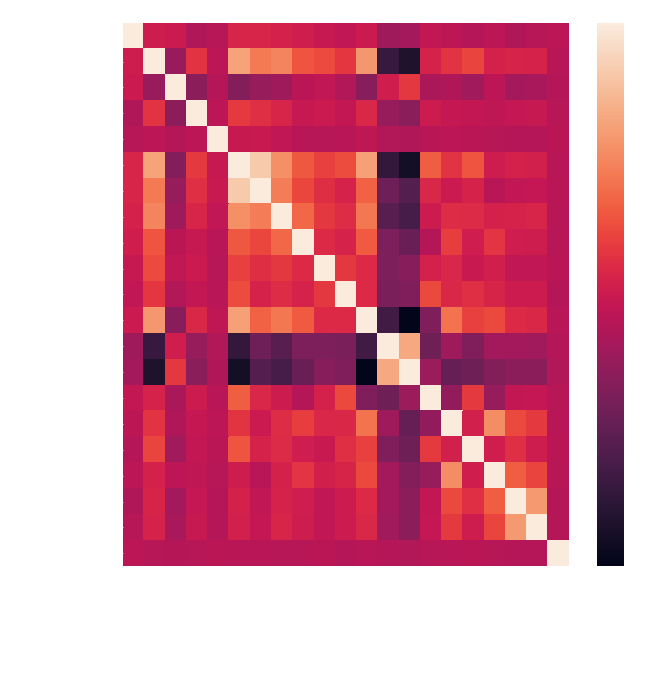

In [61]:
sns.heatmap(starcraft_data.corr()).set_title('Pearson Heat Map')

In [52]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

Text(0.5, 1.0, 'League Index Count Chart')

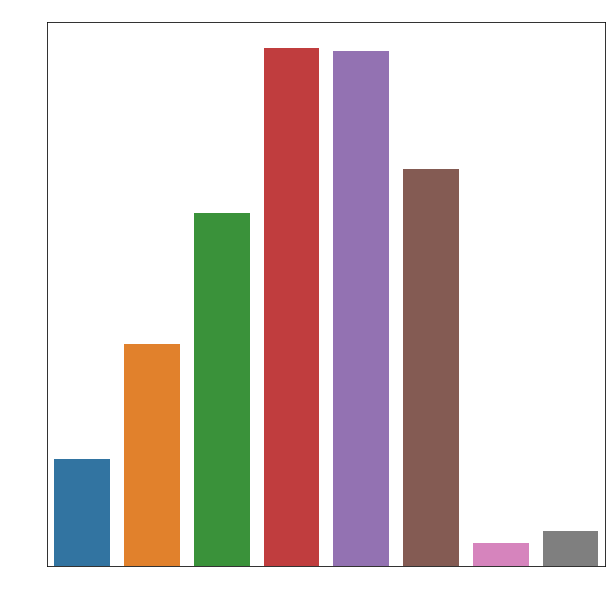

In [59]:
sns.countplot(x=starcraft_data['LeagueIndex']).set_title('League Index Count Chart')

Seems most of our data is coming from master and below. This would make sense as only 200 players from each reason are allowed in grandmaster each season and professionals typically belong in this league as well.

It seems that APM and Number of PACs have the highest positive correlations with League Index, while Action Latency and Gap Between PACs have the strongest negative correlations. At first glance, these things make sense. I have long been a starcraft enthusiast. I have spent many hours playing the game, studying the stratgies and trying to improve. One thing that was always mentioned was getting one's APM up, as a lot of professional players have an high APM. The speed at which one can process information and makes decisions correlating to a high League Index makes sense as well, this is what PAC is describing. It also makes sense that if one has bad internet connection or slow decision making skills their index would be lower. Let's explore these correlations further with some boxplots.

Text(0.5, 1.0, 'League Index vs APM')

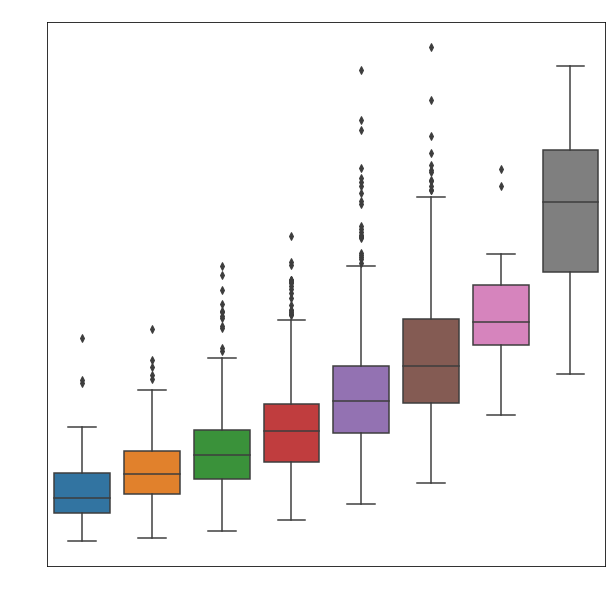

In [53]:
sns.boxplot(x='LeagueIndex', y='APM', data=starcraft_data).set_title('League Index vs APM')

Text(0.5, 1.0, 'League Index vs Number of PACs')

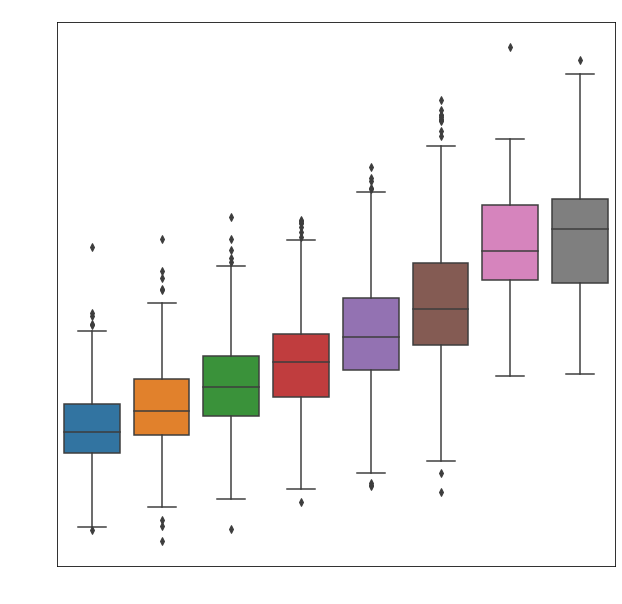

In [54]:

sns.boxplot(x='LeagueIndex', y='NumberOfPACs', data=starcraft_data).set_title('League Index vs Number of PACs')

Text(0.5, 1.0, 'League Index vs Action Latency')

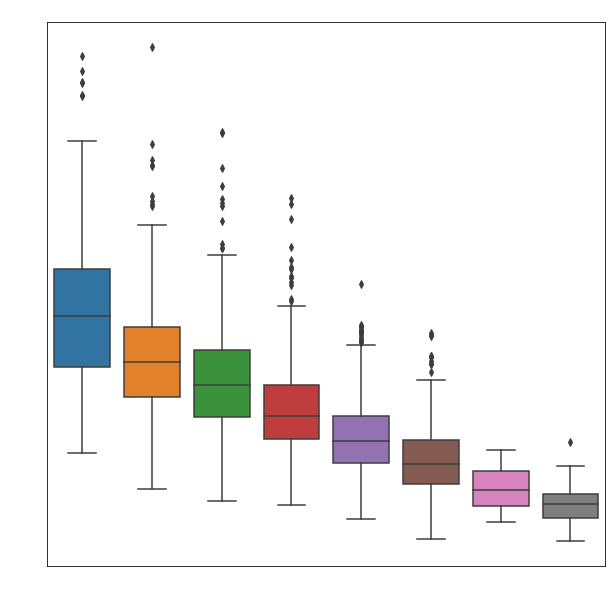

In [55]:
sns.boxplot(x='LeagueIndex', y='ActionLatency', data=starcraft_data).set_title('League Index vs Action Latency')

Text(0.5, 1.0, 'League Index vs Gap Between PACs')

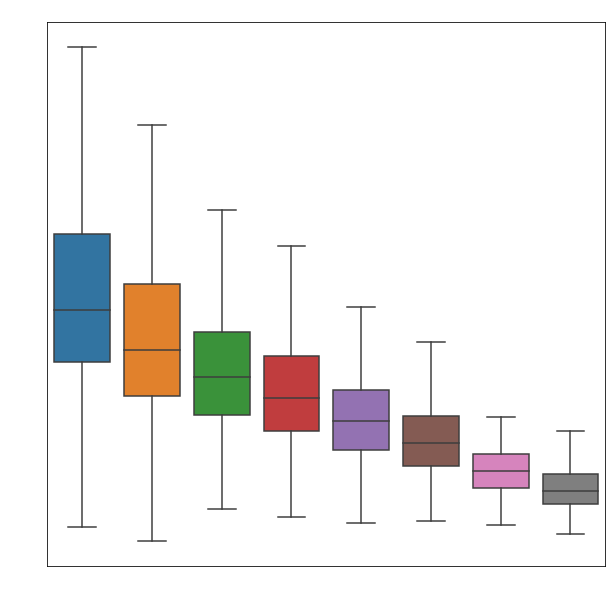

In [56]:
sns.boxplot(x='LeagueIndex', y='GapBetweenPACs', data=starcraft_data, showfliers=False).set_title('League Index vs Gap Between PACs')

The above varibles all seem important. Let's run a forest regressor algorithm to get a qunatative look at this.

In [46]:
def perm_pear_test(column, n=1000):
    list_pearson_vals = []
    og_pear_val = abs(starcraft_data.corr()['LeagueIndex'][column])
    for _ in range(n):
        starcraft_data['Permutation'] = np.random.permutation(starcraft_data[column])
        list_pearson_vals.append(starcraft_data.corr()['LeagueIndex']['Permutation'])
    return np.sum(list_pearson_vals >= og_pear_val)/len(list_pearson_vals)
        

In [42]:
apm_perm = perm_pear_test('APM', 10000)
apm_perm

0.0

In [43]:
num_pacs_perm = perm_pear_test('NumberOfPACs', 10000)
num_pacs_perm

0.0

In [47]:
lag_perm = perm_pear_test('ActionLatency', 10000)
lag_perm

0.0

In [48]:
gap_pac_perm = perm_pear_test('GapBetweenPACs', 10000)
gap_pac_perm

0.0

In [12]:
#Need to fill in some NaN values for regressor to work. Going to fill with averages
starcraft_data_nanfree = starcraft_data.copy()
starcraft_data_nanfree['Age'] = starcraft_data_nanfree['Age'].fillna(starcraft_data_nanfree['Age'].mean())
starcraft_data_nanfree['HoursPerWeek'] = starcraft_data_nanfree['HoursPerWeek'].fillna(starcraft_data_nanfree['HoursPerWeek'].mean())
starcraft_data_nanfree['TotalHours'] = starcraft_data_nanfree['TotalHours'].fillna(starcraft_data_nanfree['TotalHours'].mean())

In [13]:
X = starcraft_data_nanfree.drop(['LeagueIndex', 'GameID'], axis=1)
y = starcraft_data_nanfree['LeagueIndex']
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=10)

In [14]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Age'),
  Text(1, 0, 'HoursPerWeek'),
  Text(2, 0, 'TotalHours'),
  Text(3, 0, 'APM'),
  Text(4, 0, 'SelectByHotkeys'),
  Text(5, 0, 'AssignToHotkeys'),
  Text(6, 0, 'UniqueHotkeys'),
  Text(7, 0, 'MinimapAttacks'),
  Text(8, 0, 'MinimapRightClicks'),
  Text(9, 0, 'NumberOfPACs'),
  Text(10, 0, 'GapBetweenPACs'),
  Text(11, 0, 'ActionLatency'),
  Text(12, 0, 'ActionsInPAC'),
  Text(13, 0, 'TotalMapExplored'),
  Text(14, 0, 'WorkersMade'),
  Text(15, 0, 'UniqueUnitsMade'),
  Text(16, 0, 'ComplexUnitsMade'),
  Text(17, 0, 'ComplexAbilitiesUsed')])

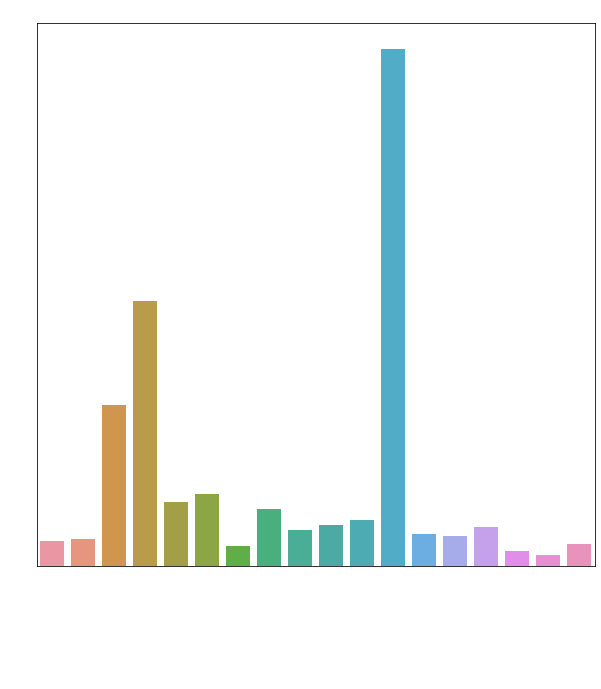

In [57]:
sns.barplot(x=X.columns, y=forest_reg.feature_importances_).set_title('RFR variable importance')
plt.xticks(rotation=90)

In [58]:
perm_impor = permutation_importance(forest_reg, X_test, y_test).set_title('RFR Permutation Variable Importance')
sns.barplot(x=X.columns, y=perm_impor.importances_mean)
plt.xticks(rotation=90)

AttributeError: set_title